In [3]:
import numpy as np
from matplotlib import pyplot as plt
from gwaxion import physics
import pandas as pd

In [5]:
# create an array of BH masses

distance = 5E6 * physics.PC_SI
mbhs = np.linspace(10, 1000, 10)
chis = np.linspace(0.5, 0.9, 5)

rows = []
for mbh in mbhs:
    for chi in chis:
        bh = physics.BlackHole(mass=mbh, chi=chi, msun=True)
        h0s, fgws, alphas = bh.scan_alphas(alpha_max=0.5, delta_alpha=0.001)
        row = {
            'mbh': mbh,
            'h0_max': h0s.max(),
            'fgw_max': fgws[np.where(h0s==h0s.max())][0],
            'chi': chi,
        }
        rows.append(row)
df = pd.DataFrame(rows)

print df.head()

   chi      fgw_max    h0_max   mbh
0  0.5   748.389156  0.000059  10.0
1  0.6   928.187968  0.000265  10.0
2  0.7  1132.996089  0.000984  10.0
3  0.8  1375.058283  0.003235  10.0
4  0.9  1678.646863  0.010005  10.0


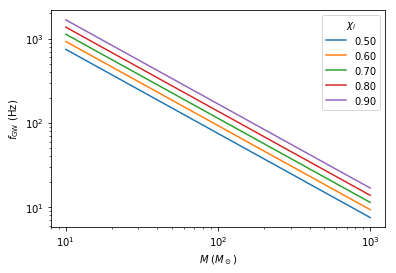

In [14]:
grouped = df.groupby('chi')

fig, ax = plt.subplots()
for chi in chis:
    df_chi = grouped.get_group(chi)
    ax.plot(df_chi['mbh'], df_chi['fgw_max'], label="%.2f" % chi)

ax.set_xlabel(r'$M$ ($M_\odot$)')
ax.set_ylabel(r'$f_{\rm GW}$ (Hz)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best', title=r"$\chi_i$")

plt.show(ax)
plt.close()

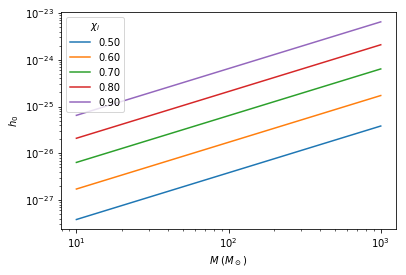

In [15]:
fig, ax = plt.subplots()
for chi in chis:
    df_chi = grouped.get_group(chi)
    ax.plot(df_chi['mbh'], df_chi['h0_max']/distance, label="%.2f" % chi)

ax.set_xlabel(r'$M$ ($M_\odot$)')
ax.set_ylabel(r'$h_0$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='best', title=r"$\chi_i$")

plt.show(ax)
plt.close()